## Natural Disaster Tweet Prediction Model (Notebook)

In [1]:
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import re
import nltk
import string
import warnings
import pickle
from scipy import interp
from spacy.lang.char_classes import LIST_PUNCT
from collections import defaultdict
from spellchecker import SpellChecker
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer, WordPunctTokenizer, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from normalization import text_cleaning, text_preprocessing
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline
from evaluation import score_df, avg_score_list
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RepeatedKFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, RocCurveDisplay
from xgboost import XGBClassifier
from wordcloud import WordCloud, ImageColorGenerator

warnings.filterwarnings('ignore')

nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
regexp = RegexpTokenizer("[\w']+")

### Data Acquisition

Loading the downloaded disaster tweets dataset. The raw tweeter dataset obtained from Kaggle contains various disaster including non-natural disaster tweets, which are outside of our research scope such as airplane crash, car accidents, riot, arson, explosions, war & many others. Hence, the twitter dataset needs to be filtered by extracting natural disaster tweets only by referring to the keyword feature. The tweets will then selected according to list of natural disasters as defined by Federal Emergency Management Agency (FEMA).

In [2]:
raw_tweets_df = pd.read_csv("./data/tweets.csv")
raw_tweets_df['keyword'] = raw_tweets_df['keyword'].str.replace(r"%20", "_")

natural_disaster_keywords = ["avalanche", "bush_fires", "cyclone", "flood", "flooding", "floods", "flames", "forest_fire", "forest_fires", "drought", "dust_storm", 
                            "earthquake", "hail", "hailstorm", "heat_wave", "hurricane", "icestorm", "landslide", "lava", "lightning", "mudslide", "rainstorm", 
                            "sandstorm", "snowstorm",  "strong_wind", "storm", "thunder", "thunderstorm", "tornado", "twister", "typhoon", "tsunami", "violent_storm", 
                            "volcanic_activity", "volcano", "volcanic", "wildfire", "wildfires", "wild_fire", "wild_fires", "whirlwind", "windstorm"]

natural_disaster_keywords_df = raw_tweets_df[raw_tweets_df['keyword'].isin(natural_disaster_keywords)].reset_index(drop=True)
non_natural_disaster_keywords_df = raw_tweets_df[~raw_tweets_df['keyword'].isin(natural_disaster_keywords)].reset_index(drop=True)
extra_natural_disaster_df = non_natural_disaster_keywords_df[non_natural_disaster_keywords_df.apply(lambda x: bool(re.search('|'.join(natural_disaster_keywords), x.text)) and x.target == 1, axis=1)]
filtered_natural_disaster_df = natural_disaster_keywords_df.append(extra_natural_disaster_df, ignore_index=True)

### Data Cleaning


Once the raw dataset has been loaded, we proceed to clean it thoroughly by conducting these processes:
1) Convert text to lowercase
2) Remove whitespaces 
3) Remove punctuations
4) Remove HTML tags
5) Remove HTML entities
6) Remove URL links
7) Remove emoji
8) Remove non-ASCII characters
9) Remove numbers

In [3]:
filtered_natural_disaster_df["cleaned_text"] = filtered_natural_disaster_df["text"].apply(text_cleaning) # implementing text cleaning

### Data Pre-Processing

Next, the cleaned disaster twitter dataset needs to be processed further before being fitted into the model for training. The pre-processsing steps taken are as below:
1) Expand contractions
2) Correct spellings
3) Remove stopwords
4) Lemmatize words

In [4]:
filtered_natural_disaster_df["normalized_text"] = filtered_natural_disaster_df["cleaned_text"].apply(text_preprocessing) # implementing text normalization
filtered_natural_disaster_df[["id", "keyword", "location", "text", "normalized_text", "target"]]

,id,keyword,location,text,normalized_text,target
0,665,avalanche,Hell,Washington has an avalanche rescue goat. His n...,Washington avalanche rescue goat his name Mazama,0
1,666,avalanche,South Africa,petition for KFC to bring back the avalanche,petition KFC bring back avalanche,0
2,667,avalanche,NaN,BSF ‘Borderman’ killed in avalanche: On Jan 13...,BSF Borderman kill avalanche on Jan evening pm...,0
3,668,avalanche,"Bangalore, India",1 BSF soldier killed in avalanche in Kashmir's...,BSF soldier kill avalanche Naugam sector perso...,1
4,669,avalanche,NaN,"Very sad news coming in. 3 soldiers killed, 1 ...",very sad news come soldier kill miss avalanche...,1
...,...,...,...,...,...,...
1719,10337,trapped,Turkey,Five soldiers were trapped under the #avalanch...,five soldier trap avalanche effort trace one m...,1
1720,10378,trapped,Jammu And Kashmir,Border Security Force: Last evening at 8:30 pm...,Border Security Force last evening pm avalanch...,1
1721,10381,trapped,"Mumbai, India",Please pray for the safety of 5 soldiers who h...,please pray safety soldier trap avalanche Mach...,1
1722,10382,trapped,UNION REPUBLIC of Hindustan,Border Security Force: Last evening at 8:30 pm...,Border Security Force last evening pm avalanch...,1


### Feature Engineering

Machine learning algorithms are unable to read text input from the dataset. Therefore, the cleaned & normalized tweet contents' needs to be converted to a numeric vector format. There are two (2) methods, based on the Bag-of-Words model that will be used in this research to vectorize the text:
1) Count
2) TF-IDF

In [5]:
X = filtered_natural_disaster_df['normalized_text'].tolist()
y = filtered_natural_disaster_df['target'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

CountVectorizer
- Counts the frequency of words in each document/ text and converts it into numerical feature vector, with each element in the vector representing the count of occureneces of the identified words within the document/ text

In [6]:
# bow = CountVectorizer()
# X_train_bow = bow.fit_transform(X_train)
# X_test_bow = bow.fit_transform(X_test)
# X_bow = bow.fit_transform(X)
# bow_model_evaluation_df = score_df(X_bow.toarray(), y)
# bow_model_evaluation_df
# bow_model_evaluation_df.to_csv("bow_model_evaluation.csv", index=False)

TF-IDF Vectorizer
- Computes the relative frequency of a word's occurences in a specified document as compared to its frequency across all other documents. It factors in the importance of each word in a document collection.

In [7]:
TFIDF = TfidfVectorizer(ngram_range = (1, 2))
X_train_tfidf = TFIDF.fit_transform(X_train)
# tfidf_model_evaluation_df = score_df(X_train_tfidf.toarray(), y_train)
# tfidf_model_evaluation_df
# tfidf_model_evaluation_df.to_csv("tfidf_model_evaluation.csv", index=False)

##### Resampling

In [8]:
#Random Oversampler with TFIDF

# ROS = RandomUnderSampler(random_state=123)
# X_train_tfidf = TFIDF.fit_transform(X_train)
# X_test_tfidf = TFIDF.fit_transform(X_test)
# X_train_ros, y_train_ros = ROS.fit_resample(X_train_tfidf, y_train)
# ros_tfidf_model_evaluation_df = score_df(X_train_ros.toarray(), y_train_ros)
# ros_tfidf_model_evaluation_df.to_csv("ros_model_evaluation.csv", index=False)

In [9]:
# #Synthetic Minority Oversampling Technique (SMOTE) oversampler with TFIDF

smote = SMOTE(random_state=123)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)
smote_tfidf_model_evaluation_df = score_df(X_train_smote.toarray(), y_train_smote)
smote_tfidf_model_evaluation_df
#smote_tfidf_model_evaluation_df.to_csv("smote_model_evaluation.csv", index=False)

,Classifier,Average_accuracy_score,Average_precision_score,Average_recall_score,Average_f1-score,Average_auc_score
0,Linear SVM,0.897981,0.992954,0.802439,0.874226,0.979601
1,Naive Bayes,0.871638,0.810117,0.971951,0.883284,0.871697
2,Random Forest,0.902857,0.961091,0.840236,0.889119,0.972367
3,XGBoost,0.867392,0.897199,0.832852,0.856655,0.937948
4,Soft Voting,0.931553,0.944718,0.919512,0.929384,0.981723
5,Hard Voting,0.909577,0.982200,0.835366,0.893682,NaN


##### Model Deployment

Since we know from our performance evaluation result done above that Ensemble Soft Voting gives the best performance, we will use that to train and fit it for deployment purposes

In [10]:
X = filtered_natural_disaster_df['normalized_text'].tolist()
y = filtered_natural_disaster_df['target'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)

TFIDF = TfidfVectorizer(ngram_range = (1, 2))
# pickle.dump(TFIDF, open('tfidf.pkl', 'wb'))
smote = SMOTE(random_state=123)

svm_linear = svm.SVC(probability=True, random_state = 123)
nb = GaussianNB()
rf = RandomForestClassifier(n_jobs = -1, random_state = 123)
xgb = XGBClassifier(eval_metric = 'logloss', random_state = 123)
soft_vote = VotingClassifier(estimators = [('svm', svm_linear), ('nb', nb), ('rf', rf), ('xgb',xgb)], voting = 'soft', n_jobs=-1) 
hard_vote = VotingClassifier(estimators = [('svm', svm_linear), ('nb', nb), ('rf', rf), ('xgb',xgb)], voting = 'hard', n_jobs=-1)
clf_list = [svm_linear, nb, rf, xgb, soft_vote, hard_vote]

X_train_tfidf = TFIDF.fit_transform(X_train)
X_test_tfidf = TFIDF.transform(X_test)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

In [11]:
soft_vote.fit(X_train_smote.toarray(), y_train_smote)
# pickle.dump(soft_vote, open('model.pkl', 'wb'))

model = pickle.load(open(r'model\softvote_model.pkl', 'rb'))
y_pred = model.predict(X_test_tfidf.toarray())
# y_pred_prob_0 = model.predict_proba(X_test_tfidf.toarray())[:, 0]
# y_pred_prob_1 = model.predict_proba(X_test_tfidf.toarray())[:, 1]

##### Visualization

Wordcloud for Predicted Real Tweets

(-0.5, 399.5, 199.5, -0.5)

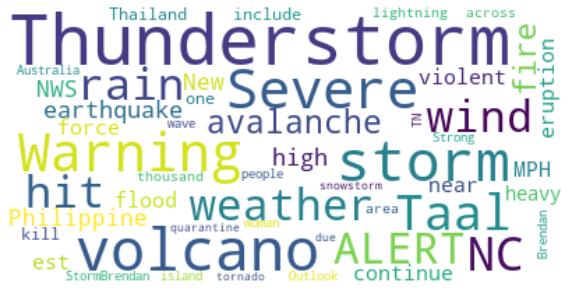

In [12]:
#Creating word cloud
wc_df = pd.DataFrame(list(zip(X_train, y_train)), columns=['text', 'actual'])
wc_df = pd.DataFrame(list(zip(X_test, y_pred, y_test)), columns=['text', 'predicted', 'actual'])

wc = WordCloud(collocations=False, max_font_size=50, max_words=50, background_color="white")
wc.generate(' '.join(wc_df[wc_df['predicted'] == 1].text))
plt.figure(figsize=(10,12))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

Wordcloud for Predicted Fake Tweets

(-0.5, 399.5, 199.5, -0.5)

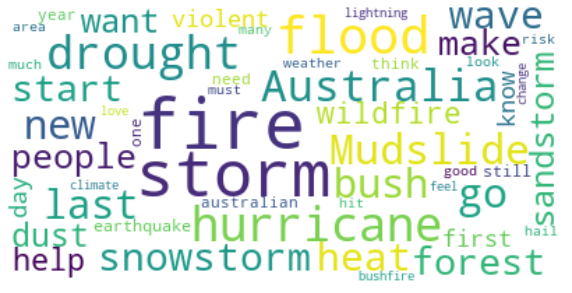

In [13]:
wc = WordCloud(collocations=False, max_font_size=50, max_words=50, background_color="white")
wc.generate(' '.join(wc_df[wc_df['predicted'] == 0].text))
plt.figure(figsize=(10,12))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

AUC-ROC Plot of Soft Voting Ensemble Model

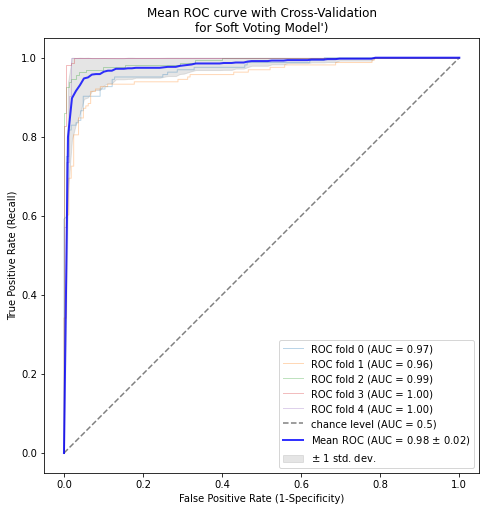

In [14]:
cv = StratifiedKFold(n_splits=5)

X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10, 8))
for fold, (train, test) in enumerate(cv.split(X_train_smote, y_train_smote)):
    soft_vote.fit(X_train_smote.toarray()[train], np.array(y_train_smote)[train])
    viz = RocCurveDisplay.from_estimator(
        soft_vote,
        X_train_smote.toarray()[test],
        np.array(y_train_smote)[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], linestyle = "--", color = 'grey', label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate (1-Specificity)",
    ylabel="True Positive Rate (Recall)",
    title=f"Mean ROC curve with Cross-Validation\nfor Soft Voting Model')",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

AUC-ROC Plot for all of the Models

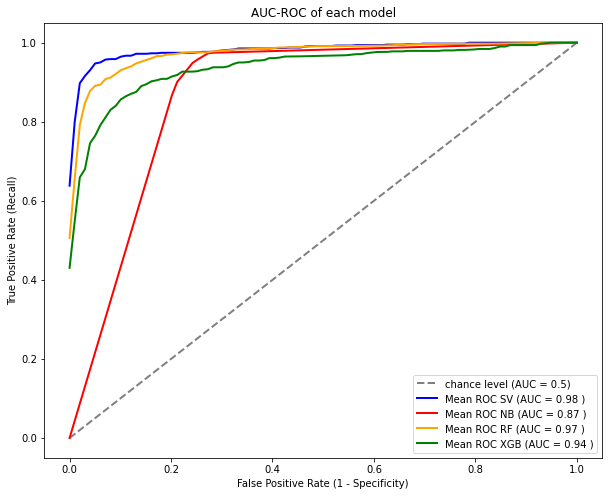

In [15]:
cv = StratifiedKFold(n_splits=5)

tprs_soft_vote, tprs_hard_vote, tprs_nb, tprs_rf, tprs_xgb = [], [], [], [], []
aucs_soft_vote, aucs_hard_vote, aucs_nb, aucs_rf, aucs_xgb = [], [], [], [], []
mean_fpr = np.linspace(0,1,100)
i = 1
fig = plt.subplots(figsize=(10, 8))

for train, test in cv.split(X_train_smote, y_train_smote):
    prediction_soft_vote = soft_vote.fit(X_train_smote.toarray()[train], np.array(y_train_smote)[train]).predict_proba(X_train_smote.toarray()[test])
    #prediction_hard_vote = hard_vote.fit(X_train_smote.toarray()[train], np.array(y_train_smote)[train]).predict_proba(X_train_smote.toarray()[test])
    prediction_nb = nb.fit(X_train_smote.toarray()[train], np.array(y_train_smote)[train]).predict_proba(X_train_smote.toarray()[test])
    prediction_rf = rf.fit(X_train_smote.toarray()[train], np.array(y_train_smote)[train]).predict_proba(X_train_smote.toarray()[test])
    prediction_xgb = xgb.fit(X_train_smote.toarray()[train], np.array(y_train_smote)[train]).predict_proba(X_train_smote.toarray()[test])

    fpr_soft_vote, tpr_soft_vote, t_soft_vote = roc_curve(np.array(y_train_smote)[test], prediction_soft_vote[:, 1])
    #fpr_hard_vote, tpr_hard_vote, t_hard_vote = roc_curve(np.array(y_train_smote)[test], prediction_hard_vote[:, 1])
    fpr_nb, tpr_nb, t_nb = roc_curve(np.array(y_train_smote)[test], prediction_nb[:, 1])
    fpr_rf, tpr_rf, t_rf = roc_curve(np.array(y_train_smote)[test], prediction_rf[:, 1])
    fpr_xgb, tpr_xgb, t_xgb = roc_curve(np.array(y_train_smote)[test], prediction_xgb[:, 1])

    tprs_soft_vote.append(interp(mean_fpr, fpr_soft_vote, tpr_soft_vote))
    #tprs_hard_vote.append(interp(mean_fpr, fpr_hard_vote, tpr_hard_vote))
    tprs_nb.append(interp(mean_fpr, fpr_nb, tpr_nb))
    tprs_rf.append(interp(mean_fpr, fpr_rf, tpr_rf))
    tprs_xgb.append(interp(mean_fpr, fpr_xgb, tpr_xgb))

    roc_auc_soft_vote = auc(fpr_soft_vote, tpr_soft_vote)
    #roc_auc_hard_vote = auc(fpr_hard_vote, tpr_hard_vote)
    roc_auc_nb = auc(fpr_nb, tpr_nb)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

    aucs_soft_vote.append(roc_auc_soft_vote)
    #aucs_hard_vote.append(roc_auc_hard_vote)
    aucs_nb.append(roc_auc_nb)
    aucs_rf.append(roc_auc_rf)
    aucs_xgb.append(roc_auc_xgb)

    #plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey', label='chance level (AUC = 0.5)')

mean_tpr_soft_vote = np.mean(tprs_soft_vote, axis=0)
#mean_tpr_hard_vote = np.mean(tprs_hard_vote, axis=0)
mean_tpr_nb = np.mean(tprs_nb, axis=0)
mean_tpr_rf = np.mean(tprs_rf, axis=0)
mean_tpr_xgb = np.mean(tprs_xgb, axis=0)

mean_auc_soft_vote = auc(mean_fpr, mean_tpr_soft_vote)
#mean_auc_hard_vote = auc(mean_fpr, mean_tpr_hard_vote)
mean_auc_nb = auc(mean_fpr, mean_tpr_nb)
mean_auc_rf = auc(mean_fpr, mean_tpr_rf)
mean_auc_xgb = auc(mean_fpr, mean_tpr_xgb)

plt.plot(mean_fpr, mean_tpr_soft_vote, color='blue', label=r'Mean ROC SV (AUC = %0.2f )' % (mean_auc_soft_vote),lw=2, alpha=1)
#plt.plot(mean_fpr, mean_tpr_hard_vote, color='blue', label=r'Mean ROC HV (AUC = %0.2f )' % (mean_auc_hard_vote),lw=2, alpha=1)
plt.plot(mean_fpr, mean_tpr_nb, color='red', label=r'Mean ROC NB (AUC = %0.2f )' % (mean_auc_nb),lw=2, alpha=1)
plt.plot(mean_fpr, mean_tpr_rf, color='orange', label=r'Mean ROC RF (AUC = %0.2f )' % (mean_auc_rf),lw=2, alpha=1)
plt.plot(mean_fpr, mean_tpr_xgb, color='green', label=r'Mean ROC XGB (AUC = %0.2f )' % (mean_auc_xgb),lw=2, alpha=1)

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('AUC-ROC of each model')
plt.legend(loc="lower right")
plt.show()